# MORDM

In [1]:
from dike_model_function import DikeNetwork 
from ema_workbench import (Model, RealParameter, ScalarOutcome, MultiprocessingEvaluator,
                           Constant, Constraint, Policy, ema_logging, Scenario)
ema_logging.log_to_stderr(ema_logging.DEBUG)
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.samplers import sample_uncertainties
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.util import utilities 

import math
import numpy as np

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D 
from ema_workbench.analysis import parcoords
import copy


In [2]:
worst_ead= pd.read_csv('Worst EAD.csv', index_col=0)
worst_end= pd.read_csv('Worst END.csv', index_col=0)
worstcases= pd.concat([worst_end,worst_ead]).drop_duplicates()
worstcases

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_Expected Annual Damage 0,A.4_Expected Number of Deaths 0,A.4_Expected Annual Damage 1,A.4_Expected Number of Deaths 1,A.4_Expected Annual Damage 2,A.4_Expected Number of Deaths 2,A.4_Expected Annual Damage 3,A.4_Expected Number of Deaths 3,Total Expected Annual Damage,Total Expected Number of Deaths
3,124.0,253.011207,10.0,0.856555,216.003097,10.0,0.704073,275.449093,1.5,0.604649,...,1.824028e+07,0.015772,2.689291e+07,0.015772,2.343772e+07,0.015772,2.059539e+07,0.015772,8.916630e+07,0.063089
24,122.0,95.390439,1.0,0.698152,70.364529,1.5,0.961340,196.509870,1.5,0.894200,...,1.227979e+07,0.010869,1.227979e+07,0.010869,1.386530e+07,0.010869,1.227979e+07,0.010869,5.070467e+07,0.043474
26,7.0,208.728219,1.0,0.613203,120.893577,1.0,0.209300,91.821676,1.0,0.568355,...,4.626732e+06,0.003482,4.626732e+06,0.003482,4.097659e+06,0.003482,4.626732e+06,0.003482,1.797786e+07,0.013929
33,41.0,330.060624,1.5,0.572942,200.632578,10.0,0.233538,217.870246,1.5,0.438413,...,2.349824e+07,0.018226,2.653225e+07,0.018226,2.349824e+07,0.018226,3.464509e+07,0.018226,1.081738e+08,0.072903
37,105.0,103.466085,1.5,0.448492,323.730308,1.5,0.580525,57.845670,1.5,0.888587,...,3.443061e+07,0.019583,2.636799e+07,0.019583,3.000698e+07,0.019583,3.443061e+07,0.019583,1.252362e+08,0.078332
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
998,72.0,47.826848,10.0,0.898242,262.964277,10.0,0.832477,312.842116,1.0,0.500048,...,3.758552e+07,0.022791,2.925073e+07,0.022791,3.758552e+07,0.022791,4.312638e+07,0.022791,1.475482e+08,0.091162
386,74.0,310.690354,10.0,0.419744,284.281345,1.0,0.724881,240.103418,1.5,0.814696,...,3.647975e+07,0.021835,2.839017e+07,0.021835,3.205579e+07,0.021835,3.647975e+07,0.021835,1.334055e+08,0.087341
393,124.0,159.647549,10.0,0.769575,136.285930,10.0,0.268660,42.267292,10.0,0.276055,...,1.686849e+07,0.010853,1.935525e+07,0.010853,1.482283e+07,0.010853,1.686849e+07,0.010853,6.791506e+07,0.043411
735,126.0,77.573443,1.5,0.406581,256.756526,1.5,0.599650,133.886739,10.0,0.958210,...,1.717656e+07,0.014520,2.207091e+07,0.014520,2.207091e+07,0.014520,2.207091e+07,0.014520,8.338928e+07,0.058080


Selecting scenarios:
1. Which has the max 'Total Expected Number of Deaths' among the worst cases
2. Which has the min 'Total Expected Number of Deaths' among the worst cases
3. Which has the max 'Total Expected Annual Damage' among the worst cases
4. Which has the min 'Total Expected Annual Damage' among the worst cases

In [51]:
sel_idx=[worstcases['Total Expected Annual Damage'].argmax(),
         worstcases['Total Expected Annual Damage'].argmin(),
         worstcases['Total Expected Number of Deaths'].argmax(),
         worstcases['Total Expected Number of Deaths'].argmin()]
sel_idx

[69, 58, 69, 58]

In [4]:
sel_idx = list(set(sel_idx)) #select only unique indexes
sel_scenario = worstcases.iloc[sel_idx,0:19]
sel_scenario

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,A.4_Bmax,A.4_Brate,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2
630,118.0,200.316801,1.5,0.766378,345.952132,10.0,0.124507,106.285786,10.0,0.638500,103.462486,1.5,0.213031,228.121140,10.0,0.276447,1.5,2.5,4.5
724,50.0,274.134883,10.0,0.996114,321.469533,10.0,0.667172,184.136099,1.5,0.657889,122.455596,10.0,0.004492,160.655295,1.5,0.144113,2.5,1.5,2.5


In [5]:
scenarios = []
for i in range(len(sel_scenario)):
    u1 = sel_scenario.iloc[i,16]
    u2 = sel_scenario.iloc[i,17]
    u3 = sel_scenario.iloc[i,18]
    u4 = sel_scenario.iloc[i,0]
    u5 = sel_scenario.iloc[i,1]
    u6 = sel_scenario.iloc[i,3]
    u7 = sel_scenario.iloc[i,2]
    u8 = sel_scenario.iloc[i,4]
    u9 = sel_scenario.iloc[i,6]
    u10 = sel_scenario.iloc[i,5]
    u11 = sel_scenario.iloc[i,7]
    u12 = sel_scenario.iloc[i,9]
    u13 = sel_scenario.iloc[i,8]
    u14 = sel_scenario.iloc[i,10]
    u15 = sel_scenario.iloc[i,12]
    u16 = sel_scenario.iloc[i,11]
    u17 = sel_scenario.iloc[i,13]
    u18 = sel_scenario.iloc[i,15]
    u19 = sel_scenario.iloc[i,14]
    scenarios.append(Scenario(f"{i}",**{"discount rate 0": u1, 
                                        "discount rate 1": u2, 
                                        "discount rate 2": u3, 
                                        "A.0_ID flood wave shape": u4, 
                                        "A.1_Bmax": u5,
                                        "A.1_pfail": u6, 
                                        "A.1_Brate": u7, 
                                        "A.2_Bmax": u8, 
                                        "A.2_pfail": u9, 
                                        "A.2_Brate": u10,
                                        "A.3_Bmax": u11, 
                                        "A.3_pfail": u12, 
                                        "A.3_Brate": u13,
                                        "A.4_Bmax": u14, 
                                        "A.4_pfail": u15, 
                                        "A.4_Brate": u16,
                                        "A.5_Bmax": u17, 
                                        "A.5_pfail": u18, 
                                        "A.5_Brate": u19
                                       }))
scenarios

'''
Scenario[0] is the 'average' case, while Scenario[1] is the 'worst' case.
'''

[Scenario({'discount rate 0': 1.5, 'discount rate 1': 2.5, 'discount rate 2': 4.5, 'A.0_ID flood wave shape': 118.0, 'A.1_Bmax': 200.31680076904223, 'A.1_pfail': 0.7663778143355962, 'A.1_Brate': 1.5, 'A.2_Bmax': 345.95213157012716, 'A.2_pfail': 0.12450679101036707, 'A.2_Brate': 10.0, 'A.3_Bmax': 106.28578576284893, 'A.3_pfail': 0.6385003347031162, 'A.3_Brate': 10.0, 'A.4_Bmax': 103.462486224363, 'A.4_pfail': 0.2130305106949248, 'A.4_Brate': 1.5, 'A.5_Bmax': 228.12113960432828, 'A.5_pfail': 0.2764474696564087, 'A.5_Brate': 10.0}),
 Scenario({'discount rate 0': 2.5, 'discount rate 1': 1.5, 'discount rate 2': 2.5, 'A.0_ID flood wave shape': 50.0, 'A.1_Bmax': 274.13488286933085, 'A.1_pfail': 0.9961140076098708, 'A.1_Brate': 10.0, 'A.2_Bmax': 321.46953311779663, 'A.2_pfail': 0.6671718905363949, 'A.2_Brate': 10.0, 'A.3_Bmax': 184.1360985503172, 'A.3_pfail': 0.6578886125253224, 'A.3_Brate': 1.5, 'A.4_Bmax': 122.45559563926909, 'A.4_pfail': 0.004491867245705115, 'A.4_Brate': 10.0, 'A.5_Bmax': 

In [6]:
dike_model, planning_steps = get_model_for_problem_formulation(5)
nopolicy = [Policy("base case", **{k.name: 0 for k in dike_model.levers})]

In [7]:
#enlisting outcomes
for outcome in dike_model.outcomes:
    print(repr(outcome))

ScalarOutcome('A.1_Expected Annual Damage 0')
ScalarOutcome('A.1_Dike Investment Costs 0')
ScalarOutcome('A.1_Expected Number of Deaths 0')
ScalarOutcome('A.2_Expected Annual Damage 0')
ScalarOutcome('A.2_Dike Investment Costs 0')
ScalarOutcome('A.2_Expected Number of Deaths 0')
ScalarOutcome('A.3_Expected Annual Damage 0')
ScalarOutcome('A.3_Dike Investment Costs 0')
ScalarOutcome('A.3_Expected Number of Deaths 0')
ScalarOutcome('A.4_Expected Annual Damage 0')
ScalarOutcome('A.4_Dike Investment Costs 0')
ScalarOutcome('A.4_Expected Number of Deaths 0')
ScalarOutcome('A.5_Expected Annual Damage 0')
ScalarOutcome('A.5_Dike Investment Costs 0')
ScalarOutcome('A.5_Expected Number of Deaths 0')
ScalarOutcome('RfR Total Costs 0')
ScalarOutcome('Expected Evacuation Costs 0')
ScalarOutcome('A.1_Expected Annual Damage 1')
ScalarOutcome('A.1_Dike Investment Costs 1')
ScalarOutcome('A.1_Expected Number of Deaths 1')
ScalarOutcome('A.2_Expected Annual Damage 1')
ScalarOutcome('A.2_Dike Investment

In [8]:
len(dike_model.outcomes)

51

In [9]:
maxEAD = max(worstcases['Total Expected Annual Damage'])
maxEND = max(worstcases['Total Expected Number of Deaths'])

In [10]:
dike_model.outcomes = [ScalarOutcome('A.1_Expected Annual Damage 0',kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEAD)),
                       ScalarOutcome('A.1_Dike Investment Costs 0',kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000000)),
                       ScalarOutcome('A.1_Expected Number of Deaths 0',kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEND)),
                       ScalarOutcome('A.1_Expected Annual Damage 1', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEAD)), 
                       ScalarOutcome('A.1_Dike Investment Costs 1', kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000000)),
                       ScalarOutcome('A.1_Expected Number of Deaths 1', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEND)),
                       ScalarOutcome('A.1_Expected Annual Damage 2', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEAD)),
                       ScalarOutcome('A.1_Dike Investment Costs 2', kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000000)),
                       ScalarOutcome('A.1_Expected Number of Deaths 2', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEND)),
                       ScalarOutcome('A.2_Expected Annual Damage 0',kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEAD)),
                       ScalarOutcome('A.2_Dike Investment Costs 0',kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000000)),
                       ScalarOutcome('A.2_Expected Number of Deaths 0',kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEND)),
                       ScalarOutcome('A.2_Expected Annual Damage 1', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEAD)), 
                       ScalarOutcome('A.2_Dike Investment Costs 1', kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000000)),
                       ScalarOutcome('A.2_Expected Number of Deaths 1', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEND)),
                       ScalarOutcome('A.2_Expected Annual Damage 2', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEAD)),
                       ScalarOutcome('A.2_Dike Investment Costs 2', kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000000)),
                       ScalarOutcome('A.2_Expected Number of Deaths 2', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEND)),
                       ScalarOutcome('A.3_Expected Annual Damage 0',kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEAD)),
                       ScalarOutcome('A.3_Dike Investment Costs 0',kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000000)),
                       ScalarOutcome('A.3_Expected Number of Deaths 0',kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEND)),
                       ScalarOutcome('A.3_Expected Annual Damage 1', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEAD)), 
                       ScalarOutcome('A.3_Dike Investment Costs 1', kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000000)),
                       ScalarOutcome('A.3_Expected Number of Deaths 1', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEND)),
                       ScalarOutcome('A.3_Expected Annual Damage 2', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEAD)),
                       ScalarOutcome('A.3_Dike Investment Costs 2', kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000000)),
                       ScalarOutcome('A.3_Expected Number of Deaths 2', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEND)),
                       ScalarOutcome('A.4_Expected Annual Damage 0',kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEAD)),
                       ScalarOutcome('A.4_Dike Investment Costs 0',kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000000)),
                       ScalarOutcome('A.4_Expected Number of Deaths 0',kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEND)),
                       ScalarOutcome('A.4_Expected Annual Damage 1', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEAD)), 
                       ScalarOutcome('A.4_Dike Investment Costs 1', kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000000)),
                       ScalarOutcome('A.4_Expected Number of Deaths 1', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEND)),
                       ScalarOutcome('A.4_Expected Annual Damage 2', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEAD)),
                       ScalarOutcome('A.4_Dike Investment Costs 2', kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000000)),
                       ScalarOutcome('A.4_Expected Number of Deaths 2', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEND)),
                       ScalarOutcome('A.5_Expected Annual Damage 0',kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEAD)),
                       ScalarOutcome('A.5_Dike Investment Costs 0',kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000000)),
                       ScalarOutcome('A.5_Expected Number of Deaths 0',kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEND)),
                       ScalarOutcome('A.5_Expected Annual Damage 1', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEAD)), 
                       ScalarOutcome('A.5_Dike Investment Costs 1', kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000000)),
                       ScalarOutcome('A.5_Expected Number of Deaths 1', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEND)),
                       ScalarOutcome('A.5_Expected Annual Damage 2', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEAD)),
                       ScalarOutcome('A.5_Dike Investment Costs 2', kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000000)),
                       ScalarOutcome('A.5_Expected Number of Deaths 2', kind=ScalarOutcome.MINIMIZE, expected_range=(0,maxEND)),
                       ScalarOutcome('RfR Total Costs 0', kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000000)),
                       ScalarOutcome('Expected Evacuation Costs 0', kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000)),
                       ScalarOutcome('RfR Total Costs 1', kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000000)),
                       ScalarOutcome('Expected Evacuation Costs 1', kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000)),
                       ScalarOutcome('RfR Total Costs 2', kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000000)),
                       ScalarOutcome('Expected Evacuation Costs 2', kind=ScalarOutcome.MINIMIZE, expected_range=(0,100000))]

In [11]:
#enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
for unc in dike_model.uncertainties:
    print(repr(unc))
    
uncertainties = dike_model.uncertainties

uncertainties = copy.deepcopy(dike_model.uncertainties)

CategoricalParameter('discount rate 0', [0, 1, 2, 3])
CategoricalParameter('discount rate 1', [0, 1, 2, 3])
CategoricalParameter('discount rate 2', [0, 1, 2, 3])
IntegerParameter('A.0_ID flood wave shape', 0, 132)
RealParameter('A.1_Bmax', 30, 350)
RealParameter('A.1_pfail', 0, 1)
CategoricalParameter('A.1_Brate', [0, 1, 2])
RealParameter('A.2_Bmax', 30, 350)
RealParameter('A.2_pfail', 0, 1)
CategoricalParameter('A.2_Brate', [0, 1, 2])
RealParameter('A.3_Bmax', 30, 350)
RealParameter('A.3_pfail', 0, 1)
CategoricalParameter('A.3_Brate', [0, 1, 2])
RealParameter('A.4_Bmax', 30, 350)
RealParameter('A.4_pfail', 0, 1)
CategoricalParameter('A.4_Brate', [0, 1, 2])
RealParameter('A.5_Bmax', 30, 350)
RealParameter('A.5_pfail', 0, 1)
CategoricalParameter('A.5_Brate', [0, 1, 2])


In [12]:
#enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
for policy in dike_model.levers:
    print(repr(policy))
    
levers = dike_model.levers 

import copy
levers = copy.deepcopy(dike_model.levers)

IntegerParameter('0_RfR 0', 0, 1)
IntegerParameter('0_RfR 1', 0, 1)
IntegerParameter('0_RfR 2', 0, 1)
IntegerParameter('1_RfR 0', 0, 1)
IntegerParameter('1_RfR 1', 0, 1)
IntegerParameter('1_RfR 2', 0, 1)
IntegerParameter('2_RfR 0', 0, 1)
IntegerParameter('2_RfR 1', 0, 1)
IntegerParameter('2_RfR 2', 0, 1)
IntegerParameter('3_RfR 0', 0, 1)
IntegerParameter('3_RfR 1', 0, 1)
IntegerParameter('3_RfR 2', 0, 1)
IntegerParameter('4_RfR 0', 0, 1)
IntegerParameter('4_RfR 1', 0, 1)
IntegerParameter('4_RfR 2', 0, 1)
IntegerParameter('EWS_DaysToThreat', 0, 4)
IntegerParameter('A.1_DikeIncrease 0', 0, 10)
IntegerParameter('A.1_DikeIncrease 1', 0, 10)
IntegerParameter('A.1_DikeIncrease 2', 0, 10)
IntegerParameter('A.2_DikeIncrease 0', 0, 10)
IntegerParameter('A.2_DikeIncrease 1', 0, 10)
IntegerParameter('A.2_DikeIncrease 2', 0, 10)
IntegerParameter('A.3_DikeIncrease 0', 0, 10)
IntegerParameter('A.3_DikeIncrease 1', 0, 10)
IntegerParameter('A.3_DikeIncrease 2', 0, 10)
IntegerParameter('A.4_DikeIncreas

In [20]:
convergence_metrics = [EpsilonProgress(), HyperVolume.from_outcomes(dike_model.outcomes)]

In [13]:
basecase = utilities.load_results('BaseCase_1000_PF5')

[MainProcess/INFO] results loaded succesfully from C:\Users\VANNESYA\Documents\Study\Q4\EPA1361\final assignment\BaseCase_1000_PF5


In [15]:
expbasecase, outcomesbasecase = basecase
outcomesbasecase = pd.DataFrame(outcomesbasecase)
outcomesbasecase

,A.1_Expected Annual Damage 0,A.1_Dike Investment Costs 0,A.1_Expected Number of Deaths 0,A.2_Expected Annual Damage 0,A.2_Dike Investment Costs 0,A.2_Expected Number of Deaths 0,A.3_Expected Annual Damage 0,A.3_Dike Investment Costs 0,A.3_Expected Number of Deaths 0,A.4_Expected Annual Damage 0,...,A.3_Dike Investment Costs 3,A.3_Expected Number of Deaths 3,A.4_Expected Annual Damage 3,A.4_Dike Investment Costs 3,A.4_Expected Number of Deaths 3,A.5_Expected Annual Damage 3,A.5_Dike Investment Costs 3,A.5_Expected Number of Deaths 3,RfR Total Costs 3,Expected Evacuation Costs 3
0,6.833754e+06,0,0.009442,3.519336e+06,0,0.006609,3.572068e+08,0,1.146792,0.000000e+00,...,0,1.146792,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.0,0.0
1,0.000000e+00,0,0.000000,1.949421e+08,0,0.281870,5.517566e+07,0,0.157227,0.000000e+00,...,0,0.157227,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.0,0.0
2,1.629577e+07,0,0.017554,1.569261e+07,0,0.022348,3.876383e+06,0,0.010514,1.651674e+07,...,0,0.010514,1.895164e+07,0,0.011292,0.000000e+00,0,0.000000,0.0,0.0
3,0.000000e+00,0,0.000000,6.378880e+06,0,0.011883,1.675471e+07,0,0.058224,1.824028e+07,...,0,0.058224,2.059539e+07,0,0.015772,0.000000e+00,0,0.000000,0.0,0.0
4,1.761271e+08,0,0.202266,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.000000e+00,...,0,0.000000,0.000000e+00,0,0.000000,1.408909e+07,0,0.023467,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,5.668782e+07,0,0.051635,2.063669e+08,0,0.228675,1.990092e+08,0,0.432029,0.000000e+00,...,0,0.432029,0.000000e+00,0,0.000000,0.000000e+00,0,0.000000,0.0,0.0
996,2.041735e+08,0,0.206898,1.576028e+06,0,0.002257,0.000000e+00,0,0.000000,1.180295e+06,...,0,0.000000,1.354294e+06,0,0.000915,0.000000e+00,0,0.000000,0.0,0.0
997,0.000000e+00,0,0.000000,1.967151e+08,0,0.285719,2.581311e+07,0,0.077666,0.000000e+00,...,0,0.077666,0.000000e+00,0,0.000000,9.465795e+05,0,0.001615,0.0,0.0
998,0.000000e+00,0,0.000000,4.569459e+06,0,0.006741,3.891234e+07,0,0.104186,3.758552e+07,...,0,0.104186,4.312638e+07,0,0.022791,0.000000e+00,0,0.000000,0.0,0.0


## Lenient

We aim to get the outcomes as follows. (We only look at A.4's outcomes)

Specifying constraints:

1. EAD 0 < mean EAD 0 of base case scenarios
2. EAD 1 < mean EAD 1 of base case scenarios
3. EAD 2 < mean EAD 2 of base case scenarios
4. END 0 < mean END 0 of base case scenarios
5. END 1 < mean END 1 of base case scenarios
6. END 2 < mean END 2 of base case scenarios

Taking mean values is preferred as the likelihood of the flood happen in Gorssel is low, but once happen the severity is considerable. Based on the Open Exploration, the around 55 percentile of the scenarios are 0 occurence of flood. Therefore, setting the constraint based on percentile will be too much (?).

However, for the best case evaluation, the 0 occurence (which is 'ambitious') will be tested after this.

In [16]:
meanEAD0 = outcomesbasecase['A.4_Expected Annual Damage 0'].mean()
meanEAD1 = outcomesbasecase['A.4_Expected Annual Damage 1'].mean()
meanEAD2 = outcomesbasecase['A.4_Expected Annual Damage 2'].mean()
meanEND0 = outcomesbasecase['A.4_Expected Number of Deaths 0'].mean()
meanEND1 = outcomesbasecase['A.4_Expected Number of Deaths 1'].mean()
meanEND2 = outcomesbasecase['A.4_Expected Number of Deaths 2'].mean()

In [35]:
meanEAD0

3944913.18273994

In [18]:
constraints1 = [Constraint("EAD 0", outcome_names="A.4_Expected Annual Damage 0",
                           function=lambda x:max(0, x-meanEAD0)),
                Constraint("EAD 1", outcome_names="A.4_Expected Annual Damage 1",
                           function=lambda x:max(0, x-meanEAD1)),
                Constraint("EAD 2", outcome_names="A.4_Expected Annual Damage 2",
                           function=lambda x:max(0, x-meanEAD2)),
                Constraint("END 0", outcome_names="A.4_Expected Number of Deaths 0",
                           function=lambda x:max(0, x-meanEND0)),
                Constraint("END 1", outcome_names="A.4_Expected Number of Deaths 1",
                           function=lambda x:max(0, x-meanEND1)),
                Constraint("END 2", outcome_names="A.4_Expected Number of Deaths 2",
                           function=lambda x:max(0, x-meanEND2))]

### Scenario 0 - The Average

In [21]:
scenarios[0]

Scenario({'discount rate 0': 1.5, 'discount rate 1': 2.5, 'discount rate 2': 4.5, 'A.0_ID flood wave shape': 118.0, 'A.1_Bmax': 200.31680076904223, 'A.1_pfail': 0.7663778143355962, 'A.1_Brate': 1.5, 'A.2_Bmax': 345.95213157012716, 'A.2_pfail': 0.12450679101036707, 'A.2_Brate': 10.0, 'A.3_Bmax': 106.28578576284893, 'A.3_pfail': 0.6385003347031162, 'A.3_Brate': 10.0, 'A.4_Bmax': 103.462486224363, 'A.4_pfail': 0.2130305106949248, 'A.4_Brate': 1.5, 'A.5_Bmax': 228.12113960432828, 'A.5_pfail': 0.2764474696564087, 'A.5_Brate': 10.0})

In [22]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results0, convergence0 = evaluator.optimize(nfe=5000, searchover='levers',
                                                 epsilons=[200000, 10000000, 0.0001, 
                                                           200000, 10000000, 0.0001,
                                                           200000, 10000000, 0.0001,
                                                           200000, 10000000, 0.0001,
                                                           200000, 10000000, 0.0001, 5000000, 5000,
                                                           200000, 10000000, 0.0001, 
                                                           200000, 10000000, 0.0001,
                                                           200000, 10000000, 0.0001,
                                                           200000, 10000000, 0.0001,
                                                           200000, 10000000, 0.0001, 5000000, 5000,
                                                           200000, 10000000, 0.0001, 
                                                           200000, 10000000, 0.0001,
                                                           200000, 10000000, 0.0001,
                                                           200000, 10000000, 0.0001,
                                                           200000, 10000000, 0.0001, 5000000, 5000],
                                                 constraints=constraints1,
                                                 reference=scenarios[0],
                                                 convergence=convergence_metrics)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 5: 499/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 10: 999/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 15: 1496/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 20: 1996/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] n

In [29]:
results0.to_csv('MORDM_S0.csv')

In [26]:
results0

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,0,1,0,0,0,0,0,1,0,1,...,2.937623e+07,0.0,0.0,2.441443e+07,0.0,0.000000e+00,4.268411e+07,0.000000,0.0,0.000000
1,0,1,1,1,1,0,1,1,0,1,...,2.900423e+07,0.0,0.0,1.046301e+07,0.0,0.000000e+00,3.167613e+07,0.000000,461900000.0,0.000000
2,1,1,0,1,1,1,0,0,0,0,...,3.166055e+07,0.0,0.0,2.611146e+07,0.0,0.000000e+00,3.489092e+07,0.000000,473900000.0,0.000000
3,0,1,1,1,0,1,0,0,0,0,...,5.057536e+07,0.0,0.0,2.666556e+07,0.0,0.000000e+00,7.611792e+07,0.000000,302400000.0,0.000000
4,0,1,0,1,1,1,0,0,0,1,...,4.430384e+07,0.0,0.0,2.852460e+07,0.0,0.000000e+00,4.830188e+07,0.000000,339000000.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4686,1,0,1,1,1,1,1,0,1,1,...,2.401277e+07,0.0,0.0,1.744711e+07,0.0,0.000000e+00,5.307686e+07,0.000000,454300000.0,0.000000
4687,0,1,0,0,0,1,1,0,1,1,...,4.329581e+07,0.0,0.0,1.097324e+07,0.0,0.000000e+00,4.338618e+07,0.000000,248500000.0,0.000000
4688,0,0,0,0,0,1,1,0,0,1,...,4.859738e+07,0.0,0.0,7.477106e+06,0.0,0.000000e+00,4.798752e+07,0.000000,339000000.0,0.000000
4689,0,1,0,0,1,1,1,1,1,0,...,4.248579e+07,0.0,0.0,1.354108e+07,0.0,0.000000e+00,0.000000e+00,0.000000,369700000.0,0.000000


In [27]:
results0['A.4_Expected Number of Deaths 0'].max()

0.0014145849846327403

In [28]:
results0['A.4_Expected Annual Damage 0'].max()

3860530.752028319

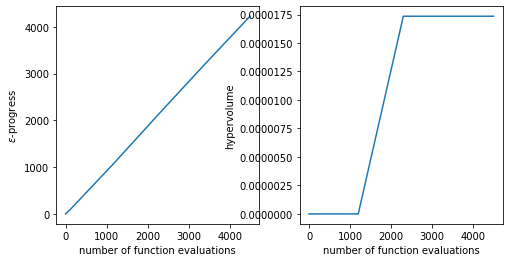

In [25]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence0.nfe, convergence0.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence0.nfe, convergence0.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [27]:
results0.loc[(results['0_RfR 0'] == 0) & (results['0_RfR 1'] == 0) & (results['0_RfR 2'] == 0) &
             (results['1_RfR 0'] == 0) & (results['1_RfR 1'] == 0) & (results['1_RfR 2'] == 0) &
             (results['2_RfR 0'] == 0) & (results['2_RfR 1'] == 0) & (results['2_RfR 2'] == 0) &
             (results['4_RfR 0'] == 0) & (results['4_RfR 1'] == 0) & (results['4_RfR 2'] == 0) &
             (results['A.1_DikeIncrease 0'] == 0) & (results['A.1_DikeIncrease 1'] == 0) &
             (results['A.1_DikeIncrease 2'] == 0) & (results['A.2_DikeIncrease 0'] == 0) &
             (results['A.2_DikeIncrease 1'] == 0) & (results['A.2_DikeIncrease 2'] == 0) &
             (results['A.3_DikeIncrease 0'] == 0) & (results['A.3_DikeIncrease 1'] == 0) &
             (results['A.3_DikeIncrease 2'] == 0) & (results['A.5_DikeIncrease 0'] == 0) &
             (results['A.5_DikeIncrease 1'] == 0) & (results['A.5_DikeIncrease 2'] == 0)]

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2


It shows that to reach the desired outcomes under the average scenario, the 'help' from other dikes is needed. Gorssel can not act alone. 

### Scenario 1 - The Worst

In [32]:
scenarios[1]

Scenario({'discount rate 0': 2.5, 'discount rate 1': 1.5, 'discount rate 2': 2.5, 'A.0_ID flood wave shape': 50.0, 'A.1_Bmax': 274.13488286933085, 'A.1_pfail': 0.9961140076098708, 'A.1_Brate': 10.0, 'A.2_Bmax': 321.46953311779663, 'A.2_pfail': 0.6671718905363949, 'A.2_Brate': 10.0, 'A.3_Bmax': 184.1360985503172, 'A.3_pfail': 0.6578886125253224, 'A.3_Brate': 1.5, 'A.4_Bmax': 122.45559563926909, 'A.4_pfail': 0.004491867245705115, 'A.4_Brate': 10.0, 'A.5_Bmax': 160.65529471929284, 'A.5_pfail': 0.14411309422052027, 'A.5_Brate': 1.5})

In [30]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results1, convergence1 = evaluator.optimize(nfe=5000, searchover='levers',
                                                epsilons=[200000, 10000000, 0.0001, 
                                                          200000, 10000000, 0.0001,
                                                          200000, 10000000, 0.0001,
                                                          200000, 10000000, 0.0001,
                                                          200000, 10000000, 0.0001, 5000000, 5000,
                                                          200000, 10000000, 0.0001, 
                                                          200000, 10000000, 0.0001,
                                                          200000, 10000000, 0.0001,
                                                          200000, 10000000, 0.0001,
                                                          200000, 10000000, 0.0001, 5000000, 5000,
                                                          200000, 10000000, 0.0001, 
                                                          200000, 10000000, 0.0001,
                                                          200000, 10000000, 0.0001,
                                                          200000, 10000000, 0.0001,
                                                          200000, 10000000, 0.0001, 5000000, 5000],
                                                constraints=constraints,
                                                reference=scenarios[1],
                                                convergence=convergence_metrics)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 5: 498/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 10: 998/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 15: 1496/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 20: 1996/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] n

In [61]:
results1.to_csv('MORDM_S1.csv')

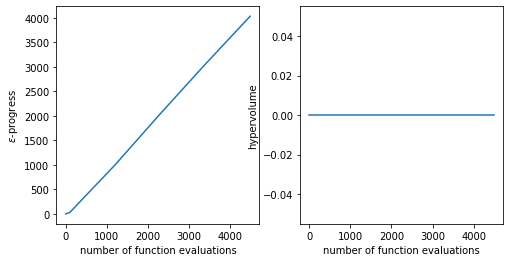

In [31]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence1.nfe, convergence1.epsilon_progress)
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence1.nfe, convergence1.hypervolume)
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()

In [54]:
results1.loc[(results['0_RfR 0'] == 0) & (results['0_RfR 1'] == 0) & (results['0_RfR 2'] == 0) &
             (results['1_RfR 0'] == 0) & (results['1_RfR 1'] == 0) & (results['1_RfR 2'] == 0) &
             (results['2_RfR 0'] == 0) & (results['2_RfR 1'] == 0) & (results['2_RfR 2'] == 0) &
             (results['4_RfR 0'] == 0) & (results['4_RfR 1'] == 0) & (results['4_RfR 2'] == 0) &
             (results['A.1_DikeIncrease 0'] == 0) & (results['A.1_DikeIncrease 1'] == 0) &
             (results['A.1_DikeIncrease 2'] == 0) & (results['A.2_DikeIncrease 0'] == 0) &
             (results['A.2_DikeIncrease 1'] == 0) & (results['A.2_DikeIncrease 2'] == 0) &
             (results['A.3_DikeIncrease 0'] == 0) & (results['A.3_DikeIncrease 1'] == 0) &
             (results['A.3_DikeIncrease 2'] == 0) & (results['A.5_DikeIncrease 0'] == 0) &
             (results['A.5_DikeIncrease 1'] == 0) & (results['A.5_DikeIncrease 2'] == 0)]

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2


It shows that to reach the desired outcomes under the worst scenario, the 'help' from other dikes is needed. Gorssel can not act alone.

## Ambitious

We only look at A.4's outcomes. Specifying constraints:

1. EAD 0 < 30 percentile of EAD 0 of base case scenarios
2. EAD 1 < 30 percentile of EAD 1 of base case scenarios
3. EAD 2 < 30 percentile of EAD 2 of base case scenarios
4. END 0 < 30 percentile of END 0 of base case scenarios
5. END 1 < 30 percentile of END 1 of base case scenarios
6. END 2 < 30 percentile of END 2 of base case scenarios

The 30th percentile is zero EAD and zero END, which means it aims for no casualty and damage at all. 

In [55]:
lowEAD0 = np.percentile(outcomesbasecase['A.4_Expected Annual Damage 0'], 30)
lowEAD1 = np.percentile(outcomesbasecase['A.4_Expected Annual Damage 1'], 30)
lowEAD2 = np.percentile(outcomesbasecase['A.4_Expected Annual Damage 2'], 30)
lowEND0 = np.percentile(outcomesbasecase['A.4_Expected Number of Deaths 0'], 30)
lowEND1 = np.percentile(outcomesbasecase['A.4_Expected Number of Deaths 1'], 30)
lowEND2 = np.percentile(outcomesbasecase['A.4_Expected Number of Deaths 2'], 30)

In [56]:
constraints2 = [Constraint("EAD 0", outcome_names="A.4_Expected Annual Damage 0",
                           function=lambda x:max(0, x-lowEAD0)),
                Constraint("EAD 1", outcome_names="A.4_Expected Annual Damage 1",
                           function=lambda x:max(0, x-lowEAD1)),
                Constraint("EAD 2", outcome_names="A.4_Expected Annual Damage 2",
                           function=lambda x:max(0, x-lowEAD2)),
                Constraint("END 0", outcome_names="A.4_Expected Number of Deaths 0",
                           function=lambda x:max(0, x-lowEND0)),
                Constraint("END 1", outcome_names="A.4_Expected Number of Deaths 1",
                           function=lambda x:max(0, x-lowEND1)),
                Constraint("END 2", outcome_names="A.4_Expected Number of Deaths 2",
                           function=lambda x:max(0, x-lowEND2))]

### Scenario 0

In [57]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results0A, convergence0A = evaluator.optimize(nfe=5000, searchover='levers',
                                                  epsilons=[200000, 10000000, 0.0001, 
                                                            200000, 10000000, 0.0001,
                                                            200000, 10000000, 0.0001,
                                                            200000, 10000000, 0.0001,
                                                            200000, 10000000, 0.0001, 5000000, 5000,
                                                            200000, 10000000, 0.0001, 
                                                            200000, 10000000, 0.0001,
                                                            200000, 10000000, 0.0001,
                                                            200000, 10000000, 0.0001,
                                                            200000, 10000000, 0.0001, 5000000, 5000,
                                                            200000, 10000000, 0.0001, 
                                                            200000, 10000000, 0.0001,
                                                            200000, 10000000, 0.0001,
                                                            200000, 10000000, 0.0001,
                                                            200000, 10000000, 0.0001, 5000000, 5000],
                                                   constraints=constraints2,
                                                   reference=scenarios[0],
                                                   convergence=convergence_metrics)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 5: 499/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 10: 997/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 15: 1493/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 20: 1991/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] n

In [58]:
results0A

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.3_Dike Investment Costs 2,A.3_Expected Number of Deaths 2,A.4_Expected Annual Damage 2,A.4_Dike Investment Costs 2,A.4_Expected Number of Deaths 2,A.5_Expected Annual Damage 2,A.5_Dike Investment Costs 2,A.5_Expected Number of Deaths 2,RfR Total Costs 2,Expected Evacuation Costs 2
0,0,1,1,0,1,0,0,1,0,0,...,4.788757e+07,0.0,0.0,8.552690e+06,0.0,0.0,9.959218e+07,0.0,461900000.0,0.0
1,0,0,1,1,1,1,0,0,1,0,...,3.972456e+07,0.0,0.0,2.758210e+07,0.0,0.0,8.419063e+07,0.0,333100000.0,0.0
2,0,1,0,1,0,0,0,0,1,1,...,3.166055e+07,0.0,0.0,2.524869e+07,0.0,0.0,0.000000e+00,0.0,30700000.0,0.0
3,0,0,0,1,0,0,1,0,1,0,...,6.500024e+07,0.0,0.0,2.493252e+07,0.0,0.0,0.000000e+00,0.0,30700000.0,0.0
4,0,0,1,1,1,1,0,1,0,1,...,6.398602e+07,0.0,0.0,2.038039e+07,0.0,0.0,4.640193e+07,0.0,679700000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4476,0,1,0,1,0,0,1,1,1,1,...,3.501832e+07,0.0,0.0,1.106038e+07,0.0,0.0,5.979835e+07,0.0,151900000.0,0.0
4477,0,0,0,0,1,1,1,0,0,0,...,3.317649e+07,0.0,0.0,1.226599e+07,0.0,0.0,4.056644e+07,0.0,217800000.0,0.0
4478,0,0,0,0,0,0,1,1,0,0,...,3.406668e+07,0.0,0.0,7.996835e+06,0.0,0.0,5.132310e+07,0.0,377300000.0,0.0
4479,0,0,0,0,0,0,1,0,0,0,...,3.820980e+07,0.0,0.0,1.311859e+07,0.0,0.0,3.471760e+07,0.0,256100000.0,0.0


In [63]:
results0A.to_csv('MORDM_S0A.csv')

### Scenario 1

In [64]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results1A, convergence1A = evaluator.optimize(nfe=5000, searchover='levers',
                                                  epsilons=[200000, 10000000, 0.0001, 
                                                            200000, 10000000, 0.0001,
                                                            200000, 10000000, 0.0001,
                                                            200000, 10000000, 0.0001,
                                                            200000, 10000000, 0.0001, 5000000, 5000,
                                                            200000, 10000000, 0.0001, 
                                                            200000, 10000000, 0.0001,
                                                            200000, 10000000, 0.0001,
                                                            200000, 10000000, 0.0001,
                                                            200000, 10000000, 0.0001, 5000000, 5000,
                                                            200000, 10000000, 0.0001, 
                                                            200000, 10000000, 0.0001,
                                                            200000, 10000000, 0.0001,
                                                            200000, 10000000, 0.0001,
                                                            200000, 10000000, 0.0001, 5000000, 5000],
                                                   constraints=constraints2,
                                                   reference=scenarios[1],
                                                   convergence=convergence_metrics)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 5: 500/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 10: 997/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 15: 1494/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 20: 1994/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] n

In [65]:
results1A.to_csv('MORDM_S1A.csv')

# TEST

Try to increase the epsilon again, to get fewer solutions. 

In [ ]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results1T, convergence1T = evaluator.optimize(nfe=5000, searchover='levers',
                                                  epsilons=[200000, 20000000, 0.0001, 
                                                            200000, 20000000, 0.0001,
                                                            200000, 20000000, 0.0001,
                                                            200000, 20000000, 0.0001,
                                                            200000, 20000000, 0.0001, 10000000, 5000,
                                                            200000, 20000000, 0.0001, 
                                                            200000, 20000000, 0.0001,
                                                            200000, 20000000, 0.0001,
                                                            200000, 20000000, 0.0001,
                                                            200000, 20000000, 0.0001, 10000000, 5000,
                                                            200000, 20000000, 0.0001, 
                                                            200000, 20000000, 0.0001,
                                                            200000, 20000000, 0.0001,
                                                            200000, 20000000, 0.0001,
                                                            200000, 20000000, 0.0001, 10000000, 5000],
                                                   constraints=constraints2,
                                                   reference=scenarios[1],
                                                   convergence=convergence_metrics)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 5: 497/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 10: 996/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 15: 1496/5000 nfe
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/DEBUG] none received
[MainProcess/INFO] generation 20: 1995/5000 nfe
